<a href="https://colab.research.google.com/github/CheenapalliRachana/AI_Assignments/blob/master/dogvscat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import os
from random import shuffle
import cv2
from google.colab import drive
drive.mount("/content/drive")
train_file="/content/drive/My Drive/Colab Notebooks/train.zip"
test_file="/content/drive/My Drive/Colab Notebooks/test.zip"
import zipfile
with zipfile.ZipFile(train_file,'r') as z:
  z.extractall()
with zipfile.ZipFile(test_file,'r') as z:
  z.extractall()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
TEST_DIR="./test/"
TRAIN_DIR="./train/"
LEARNING_RATE=1e-3
MODEL_NAME="dogvscats-{}-{}.model".format(LEARNING_RATE,"6conv-fire")
IMG_SIZE=50
def label_image(img):
  img_name=img.split(".")[-3]
  if img_name=="cat":
    return[1,0]
  elif img_name=="dog":
    return[0,1]

In [0]:
def create_train_data():
  training_data=[]
  
  for img in tqdm(os.listdir(TRAIN_DIR)):
      label=label_image(img)
      path=os.path.join(TRAIN_DIR,img)
      img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
      img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
      training_data.append([np.array(img),np.array(label)])
  shuffle(training_data)
  np.save('train_data.npy',training_data)
  return training_data
train_data=create_train_data()
    

100%|██████████| 25000/25000 [00:21<00:00, 1175.99it/s]


In [0]:
import tflearn
from tflearn.layers.conv import conv_2d,max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
import tensorflow as tf
tf.reset_default_graph()

convnet=input_data(shape=[None,IMG_SIZE,IMG_SIZE,1],name='input')

convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=conv_2d(convnet,128,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=fully_connected(convnet,1024,activation='relu')
convnet=dropout(convnet,0.8)

convnet=fully_connected(convnet,2,activation='softmax')
convnet=regression(convnet,optimizer='adam',learning_rate=LEARNING_RATE,loss='categorical_crossentropy',name='targets')

model=tflearn.DNN(convnet,tensorboard_dir='log')

if os.path.exists('{}.meta'.format(MODEL_NAME)):
  model.load(MODEL_NAME)
  print('model loaded')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [0]:
train=train_data[:-500]
test=train_data[-500:]

X=np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y=[i[1] for i in train]

test_x=np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y=[i[1] for i in test]

model.fit({'input':X},{'targets':Y},n_epoch=3,validation_set=({'input':test_x},{'targets':test_y}),
         snapshot_step=500,show_metric=True,run_id=MODEL_NAME)

Training Step: 2297  | total loss: 0.36335 | time: 4.435s
| Adam | epoch: 006 | loss: 0.36335 - acc: 0.8351 -- iter: 24448/24500
Training Step: 2298  | total loss: 0.35855 | time: 5.446s
| Adam | epoch: 006 | loss: 0.35855 - acc: 0.8406 | val_loss: 0.46181 - val_acc: 0.7920 -- iter: 24500/24500
--


In [0]:
testing_data =[]
for img in tqdm(os.listdir("./test/")):
    path=os.path.join("./test",img)
    img_num=img.split('.')[0]
    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
    testing_data.append([np.array(img),img_num])

100%|██████████| 12500/12500 [00:10<00:00, 1160.33it/s]


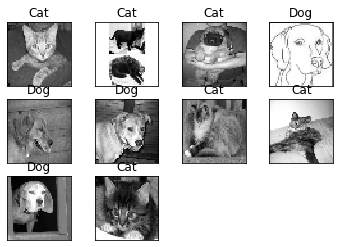

In [0]:
fig=plt.figure()

for num,data in enumerate(testing_data[:10]):
    #cat: [1,0]
    #dog: [0,1]
    
    img_num=data[1]
    img_data=data[0]
    
    y=fig.add_subplot(3,4,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out=model.predict([data])[0]
    
    if np.argmax(model_out)==1: str_label='Dog'
    else: str_label='Cat'  
      
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()    
    